# 独立成分分析 Lab

在此 notebook 中，我们将使用独立成分分析方法从三个观察结果中提取信号，每个观察结果都包含不同的原始混音信号。这个问题与 ICA 视频中解释的问题一样。

## 数据集
首先看看手头的数据集。我们有三个 WAVE 文件，正如我们之前提到的，每个文件都是混音形式。如果你之前没有在 python 中处理过音频文件，没关系，它们实际上就是浮点数列表。


首先加载第一个音频文件 **[ICA_mix_1.wav](ICA_mix_1.wav)** [点击即可聆听该文件]：

In [1]:
import numpy as np
import wave

# Read the wave file
mix_1_wave = wave.open('ICA_mix_1.wav','r')

我们看看该 wave 文件的参数，详细了解该文件

In [2]:
mix_1_wave.getparams()

_wave_params(nchannels=1, sampwidth=2, framerate=44100, nframes=264515, comptype='NONE', compname='not compressed')

该文件只有一个声道（因此是单声道）。帧率是 44100，表示每秒声音由 44100 个整数组成（因为文件是常见的 PCM 16 位格式，所以是整数）。该文件总共有 264515 个整数/帧，因此时长为：

In [3]:
264515/44100

5.998072562358277

我们从该 wave 文件中提取帧，这些帧将属于我们将运行 ICA 的数据集：

In [4]:
# Extract Raw Audio from Wav File
signal_1_raw = mix_1_wave.readframes(-1)
signal_1 = np.fromstring(signal_1_raw, 'Int16')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


signal_1 现在是一个整数列表，表示第一个文件中包含的声音。

In [5]:
'length: ', len(signal_1) , 'first 100 elements: ',signal_1[:100]

('length: ',
 264515,
 'first 100 elements: ',
 array([  879,  1268,  1460,  1756,  1943,  2216,  2407,  2668,  2866,
         3106,  3308,  3546,  3752,  3981,  4175,  4395,  4588,  4790,
         4966,  5146,  5292,  5436,  5550,  5643,  5717,  5759,  5790,
         5798,  5789,  5756,  5713,  5649,  5576,  5478,  5381,  5267,
         5146,  4999,  4856,  4682,  4502,  4308,  4097,  3875,  3637,
         3380,  3107,  2825,  2514,  2194,  1847,  1472,  1087,   671,
          227,  -219,  -691, -1176, -1666, -2167, -2669, -3179, -3668,
        -4170, -4643, -5116, -5559, -5985, -6380, -6765, -7105, -7422,
        -7706, -7955, -8163, -8339, -8470, -8557, -8600, -8618, -8585,
        -8524, -8425, -8298, -8129, -7947, -7720, -7475, -7205, -6916,
        -6606, -6266, -5922, -5556, -5165, -4774, -4353, -3922, -3476, -3021], dtype=int16))

如果将此数组绘制成线形图，我们将获得熟悉的波形：

In [6]:
import matplotlib.pyplot as plt

fs = mix_1_wave.getframerate()
timing = np.linspace(0, len(signal_1)/fs, num=len(signal_1))


plt.figure(figsize=(12,2))
plt.title('Recording 1')
plt.plot(timing,signal_1, c="#3ABFE7")
plt.ylim(-35000, 35000)
plt.show()

![png](output_11_1.png)


现在我们可以按照相同的方式加载另外两个 wave 文件 **[ICA_mix_2.wav](ICA_mix_2.wav)** 和 **[ICA_mix_3.wav](ICA_mix_3.wav)**

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  del sys.path[0]


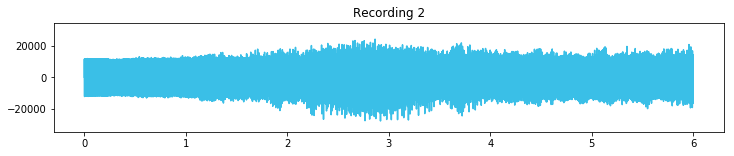

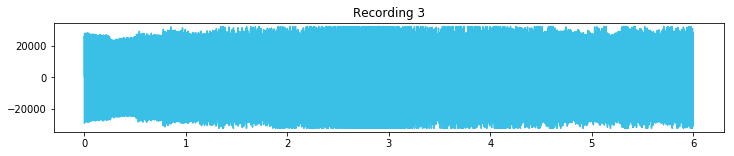

In [7]:

mix_2_wave = wave.open('ICA_mix_2.wav','r')

#Extract Raw Audio from Wav File
signal_raw_2 = mix_2_wave.readframes(-1)
signal_2 = np.fromstring(signal_raw_2, 'Int16')


mix_3_wave = wave.open('ICA_mix_3.wav','r')

#Extract Raw Audio from Wav File
signal_raw_3 = mix_3_wave.readframes(-1)
signal_3 = np.fromstring(signal_raw_3, 'Int16')


plt.figure(figsize=(12,2))
plt.title('Recording 2')
plt.plot(timing,signal_2, c="#3ABFE7")
plt.ylim(-35000, 35000)
plt.show()


plt.figure(figsize=(12,2))
plt.title('Recording 3')
plt.plot(timing,signal_3, c="#3ABFE7")
plt.ylim(-35000, 35000)
plt.show()


读取所有三个文件后，可以通过 [zip](https://docs.python.org/3/library/functions.html#zip) 运算创建数据集。

* 通过将 signal_1、signal_2 和 signal_3 组合成一个列表创建数据集 ```X```

In [8]:
X = list(zip(signal_1, signal_2, signal_3))

# Let's peak at what X looks like
X[:10]

[(879, 157, 879),
 (1268, 899, 2584),
 (1460, 1610, 4081),
 (1756, 2325, 5682),
 (1943, 3022, 7147),
 (2216, 3718, 8689),
 (2407, 4386, 10114),
 (2668, 5056, 11583),
 (2866, 5690, 12954),
 (3106, 6318, 14327)]

现在准备运行 ICA 以尝试获取原始信号。

* 导入 sklearn 的 [FastICA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html) 模块
* 初始化 FastICA，查看三个成分
* 使用 fit_transform 对数据集 X 运行 FastICA 算法

In [9]:
# TODO: Import FastICA
from sklearn.decomposition import FastICA

# TODO: Initialize FastICA with n_components=3
ica = FastICA(n_components=3)

# TODO: Run the FastICA algorithm using fit_transform on dataset X
ica_result = ica.fit_transform(X)

In [10]:
ica_result.shape

(264515, 3)

我们将其拆分为单独的信号并查看这些信号

In [11]:
result_signal_1 = ica_result[:,0]
result_signal_2 = ica_result[:,1]
result_signal_3 = ica_result[:,2]

我们对信号进行绘制，查看波浪线的形状

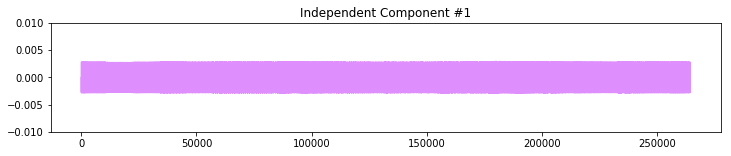

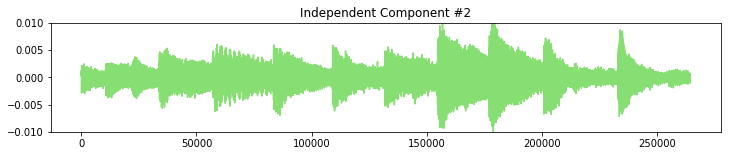

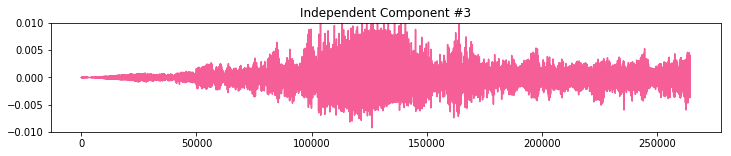

In [12]:
# Plot Independent Component #1
plt.figure(figsize=(12,2))
plt.title('Independent Component #1')
plt.plot(result_signal_1, c="#df8efd")
plt.ylim(-0.010, 0.010)
plt.show()

# Plot Independent Component #2
plt.figure(figsize=(12,2))
plt.title('Independent Component #2')
plt.plot(result_signal_2, c="#87de72")
plt.ylim(-0.010, 0.010)
plt.show()

# Plot Independent Component #3
plt.figure(figsize=(12,2))
plt.title('Independent Component #3')
plt.plot(result_signal_3, c="#f65e97")
plt.ylim(-0.010, 0.010)
plt.show()



某些波浪线看起来像音乐波形吗？

确认结果的最佳方式是聆听生成的文件。另存为 wave 文件并进行验证。在此之前，我们需要：

* 将它们转换为整数（以便另存为 PCM 16 位 Wave 文件），否则只有某些媒体播放器能够播放它们
* 将值映射到 int16 音频的相应范围内。该范围在 -32768 到 +32767 之间。基本的映射方法是乘以 32767。
* 音量有点低，我们可以乘以某个值（例如 100）来提高音量

In [13]:
from scipy.io import wavfile

# Convert to int, map the appropriate range, and increase the volume a little bit
result_signal_1_int = np.int16(result_signal_1*32767*100)
result_signal_2_int = np.int16(result_signal_2*32767*100)
result_signal_3_int = np.int16(result_signal_3*32767*100)


# Write wave files
wavfile.write("result_signal_1.wav", fs, result_signal_1_int)
wavfile.write("result_signal_2.wav", fs, result_signal_2_int)
wavfile.write("result_signal_3.wav", fs, result_signal_3_int)

现在生成的文件包括：[注意：确保先调低音响设备的音量，以防某些问题导致文件听起来像静态的]

* [result_signal_1.wav](result_signal_1.wav)
* [result_signal_2.wav](result_signal_2.wav)
* [result_signal_3.wav](result_signal_3.wav)


音乐：

* 钢琴 - The Carnival of the Animals - XIII. The Swan（钢琴曲独奏版）。演奏者：Markus Staab
* 大提琴 - Cello Suite no. 3 in C, BWV 1009 - I. Prelude。演奏者：European Archive